# Boilerplate

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# pip install git+https://github.com/scikit-optimize/scikit-optimize.git

In [38]:
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

In [40]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [41]:
from skopt import dummy_minimize, gp_minimize, forest_minimize, gbrt_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args

In [43]:
from hyperopt import hp, tpe, fmin, Trials
from hyperopt import anneal, tpe

# Data preparation

In [45]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [54]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [55]:
# encode targets
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

# Define CNN - Functional API model

In [58]:
def create_cnn(learning_rate, num_dense_layers, num_dense_nodes, activation):
  inputs = keras.Input(shape=(28,28,1))
  x = layers.Conv2D(kernel_size=5, strides=1, filters=16,padding='same',
                    activation=activation)(inputs)
  x = layers.MaxPool2D(pool_size=2, strides=2)(x)
  x = layers.Conv2D(kernel_size=5, strides=1, filters=36,padding='same',
                    activation=activation)(x)
  x = layers.MaxPool2D(pool_size=2, strides=2)(x)
  x = layers.Flatten()(x)
  for i in range(num_dense_layers):
    x = layers.Dense(num_dense_nodes, activation=activation)(x)
  outputs = layers.Dense(10, activation='softmax')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

# Define hyperparameter space

In [59]:
skopt_param_grid = [
    Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate'),
    Integer(low=1, high=5, name='num_dense_layers'),
    Integer(low=5, high=512, name='num_dense_nodes'),
    Categorical(categories=['relu', 'sigmoid'], name='activation')
]

In [60]:
# determine the hyperparameter space

hyperopt_param_grid = {
    'learning_rate': hp.uniform('learning_rate', 1e-6, 1e-2),
    # 'num_conv_layers': hp.quniform('num_conv_layers', 1, 3, 1),
    'num_dense_layers': hp.quniform('num_dense_layers', 1, 5, 1),
    'num_dense_nodes': hp.quniform('num_dense_nodes', 5, 512, 1),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
}

# Define objective functions

In [64]:
# starting point for the optimization
best_accuracy = 0

In [65]:
@use_named_args(skopt_param_grid)
def skopt_objective(learning_rate, num_dense_layers, num_dense_nodes, activation):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()

    # create model
    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)
    
    # set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)
    # train model
    history = model.fit(x=x_train, y=y_train,
                        epochs=3, batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)
    
    # get accuracy
    accuracy = history.history['val_accuracy'][-1]
  
    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy

    if accuracy > best_accuracy:
      # model.save(path_best_model)
      best_accuracy = accuracy
    
    del model
    return -accuracy

In [66]:
def hyperopt_objective(params):
    # Print the hyper-parameters.        
    print('learning rate: ', params['learning_rate'])
    # print('num_conv_layers: ', int(params['num_conv_layers']))
    print('num_dense_layers: ',int(params['num_dense_layers']))
    print('num_dense_nodes: ', int(params['num_dense_nodes']))
    print('activation: ', params['activation'])
    print()

    model = create_cnn(learning_rate=params['learning_rate'],
                      #  num_conv_layers=int(params['num_conv_layers']),
                       num_dense_layers=int(params['num_dense_layers']),
                       num_dense_nodes=int(params['num_dense_nodes']),
                       activation=params['activation'],
                       )

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
    
    history = model.fit(x=x_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)
    
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy

    if accuracy > best_accuracy:
        # model.save(path_best_model)
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    return -accuracy

# Optimization algorithms

## 1. Randomized Search

In [ ]:
random_start = time.time()
random_search = dummy_minimize(
    skopt_objective,  
    skopt_param_grid,  
    n_calls=50,  
    random_state=0
)
random_time = time.time() - random_start

In [81]:
"Best score=%.4f" % random_search.fun

'Best score=-0.9865'

In [82]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (random_search.x[0], 
                random_search.x[1],
                random_search.x[2],
                random_search.x[3]))

Best parameters:
- learning rate=0.000270
- num_dense_layers=5
- num_nodes=126
- activation = relu


## 2. Bayes Optimization with Gaussian Process

In [ ]:
gp_start = time.time()
gp_search = gp_minimize(
    skopt_objective, 
    skopt_param_grid, 
    n_initial_points=10, 
    acq_func='EI', 
    n_calls=50, 
    random_state=0
)
gp_time = time.time() - gp_start

In [83]:
"Best score=%.4f" % gp_search.fun

'Best score=-0.9855'

In [84]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (gp_search.x[0], 
                gp_search.x[1],
                gp_search.x[2],
                gp_search.x[3]))

Best parameters:
- learning rate=0.000405
- num_dense_layers=5
- num_nodes=512
- activation = relu


## 3. Bayes Optimization with Random Forests

In [ ]:
fm_start = time.time()
fm_search = forest_minimize(
    skopt_objective, 
    skopt_param_grid, 
    base_estimator = 'RF', 
    n_initial_points=10, 
    acq_func='EI', 
    n_calls=50, 
    random_state=0, 
    n_jobs=5,
)
fm_time = time.time() - fm_start

In [85]:
"Best score=%.4f" % fm_search.fun

'Best score=-0.9880'

In [86]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (fm_search.x[0], 
                fm_search.x[1],
                fm_search.x[2],
                fm_search.x[3]))

Best parameters:
- learning rate=0.003259
- num_dense_layers=3
- num_nodes=373
- activation = sigmoid


## 4. Bayes Optimization with GBM

In [ ]:
gbm_start = time.time()
gbm_search = gbrt_minimize(
    skopt_objective,
    skopt_param_grid, 
    n_initial_points=10, 
    acq_func='EI', 
    n_calls=50, 
    random_state=0, 
    n_jobs=5,
)
gbm_time = time.time() - gbm_start

In [87]:
"Best score=%.4f" % gbm_search.fun

'Best score=-0.9877'

In [88]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (gbm_search.x[0], 
                gbm_search.x[1],
                gbm_search.x[2],
                gbm_search.x[3]))

Best parameters:
- learning rate=0.000768
- num_dense_layers=5
- num_nodes=388
- activation = relu


## 5. Annealing Search

In [ ]:
anneal_start = time.time()
trials_anneal = Trials()
anneal_search = fmin(
    fn=hyperopt_objective,
    space=hyperopt_param_grid,
    max_evals=50,
    algo=anneal.suggest,
    trials = trials_anneal
)
anneal_time = time.time() - anneal_start

In [72]:
anneal_results = [trials_anneal.results[i]['loss'] for i in range(len(trials_anneal))]
mins_anneal = [np.min(anneal_results[:i]) for i in range(1, len(anneal_results)+1)]

## 6. Tree-structured Parzen Estimators Search

In [ ]:
tpe_start = time.time()
trials_tpe = Trials()
tpe_search = fmin(
    fn=hyperopt_objective,
    space=hyperopt_param_grid,
    max_evals=50,
    algo=tpe.suggest,
    trials = trials_tpe
)
tpe_time = time.time() - tpe_start

In [74]:
tpe_results = [trials_tpe.results[i]['loss'] for i in range(len(trials_tpe))]
mins_tpe = [np.min(tpe_results[:i]) for i in range(1, len(tpe_results)+1)]

# Plot Charts

In [75]:
names = ['random_search', 'gp_search', 'fm_search', 
        'gbm_search', 'anneal_search', 'tpe_search']
convergence_results = [random_search, gp_search, fm_search, gbm_search]
time_results = [random_time, gp_time, fm_time, gbm_time, anneal_time, tpe_time]

In [76]:
n_calls = len(convergence_results[0].x_iters)
iterations = range(1, n_calls+1)
mins = [[np.min(r.func_vals[:i]) for i in iterations]
                for r in convergence_results]
mins.append(mins_anneal)
mins.append(mins_tpe)

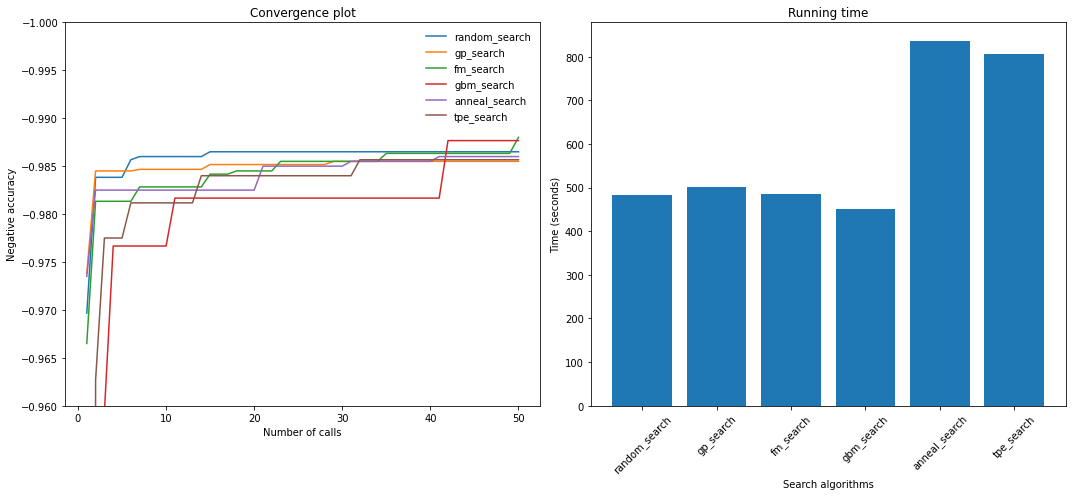

In [91]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
for min, name in zip(mins,names):
    axes[0].plot(iterations, min, label=name)
axes[0].set_ylim(-0.96, -1)
axes[0].set_title('Convergence plot')
axes[0].set_ylabel('Negative accuracy')
axes[0].set_xlabel('Number of calls')
axes[0].legend(frameon=False)

axes[1].bar(names, time_results)
axes[1].set_xticklabels(names, rotation=45)
# axes[1].set_ylim(0,100)
axes[1].set_title('Running time')
axes[1].set_xlabel('Search algorithms')
axes[1].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.show()
# plt.savefig('convergence_plot.jpg')